<a href="https://colab.research.google.com/github/saulolks/HandTracking/blob/master/hand_gestures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 2 - Projeto PDI
### Aplicação de filtros para obtenção do objeto de interesse removendo partes desnecessárias da imagem.

In [267]:
import cv2
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

!git clone https://github.com/saulolks/HandTracking

fatal: destination path 'HandTracking' already exists and is not an empty directory.


In [0]:
wsize_open = 13
wsize_gaussian = 13

y_min = 54
y_max = 137
crmin = 135
crmax = 174
cbmin = 80
cbmax = 125

In [0]:
headcascade = cv2.CascadeClassifier('HandTracking/face.xml')
backSub = cv2.createBackgroundSubtractorKNN(history=500, dist2Threshold=30)
kernel = np.ones((wsize_open, wsize_open), np.uint8)

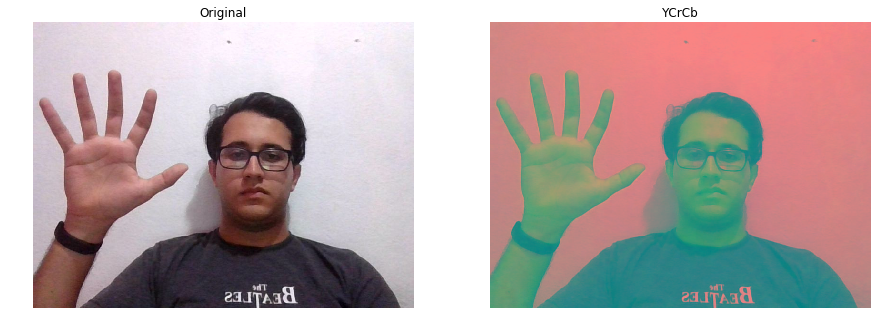

In [270]:
original = cv2.imread('HandTracking/images/sample.jpg')
image = cv2.cvtColor(original, cv2.COLOR_BGR2YCR_CB)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes.ravel()
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(image)
ax[1].set_title('YCrCb')
ax[1].set_axis_off()

## Converte em tons de cinza
Localiza a face na imagem em tons de cinza.

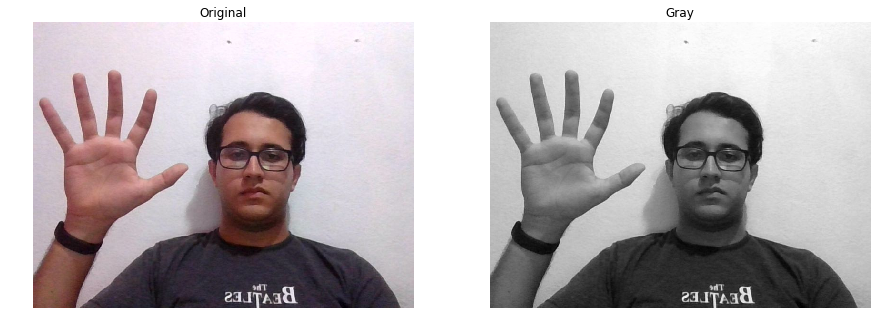

In [271]:
image_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
faces = headcascade.detectMultiScale(image_gray, 1.3, 5)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes.ravel()
ax[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(image_gray, cmap='gray')
ax[1].set_title('Gray')
ax[1].set_axis_off()

### Divide imagem YCrCb em 3 canais distintos

In [0]:
y, cr, cb = cv2.split(image)

### Binarização

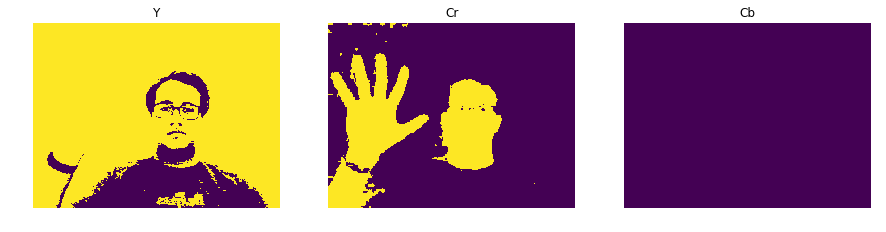

In [273]:
_, y = cv2.threshold(y, y_min, y_max, cv2.THRESH_BINARY)
_, cr = cv2.threshold(cr, crmin, crmax, cv2.THRESH_BINARY)
_, cb = cv2.threshold(cb, cbmin, cbmax, cv2.THRESH_BINARY)

fig, axes = plt.subplots(1, 3, figsize=(15, 8))
ax = axes.ravel()

ax[0].imshow(y)
ax[0].set_title('Y')
ax[0].set_axis_off()

ax[1].imshow(cr)
ax[1].set_title('Cr')
ax[1].set_axis_off()

ax[2].imshow(cb)
ax[2].set_title('Cb')
ax[2].set_axis_off()

### Morfologia
Utiliza transformações morfológicas de abertura para remoção de pequenos artefatos na imagem.

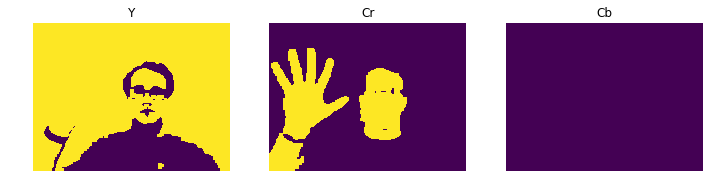

In [274]:
y = cv2.morphologyEx(y, cv2.MORPH_OPEN, kernel)
cr = cv2.morphologyEx(cr, cv2.MORPH_OPEN, kernel)
cb = cv2.morphologyEx(cb, cv2.MORPH_OPEN, kernel)

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(y)
ax[0].set_title('Y')
ax[0].set_axis_off()

ax[1].imshow(cr)
ax[1].set_title('Cr')
ax[1].set_axis_off()

ax[2].imshow(cb)
ax[2].set_title('Cb')
ax[2].set_axis_off()

### Merge

In [0]:
def remove_concomponent(img, min_value):
    shape = (len(img), len(img[0]))
    img2 = np.zeros(shape)

    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    for i in range(0, nb_components):
        if sizes[i] >= min_value:
            img2[output == i + 1] = 255

    return img2.astype(np.uint8)

### Juntando os filtros e binarizando

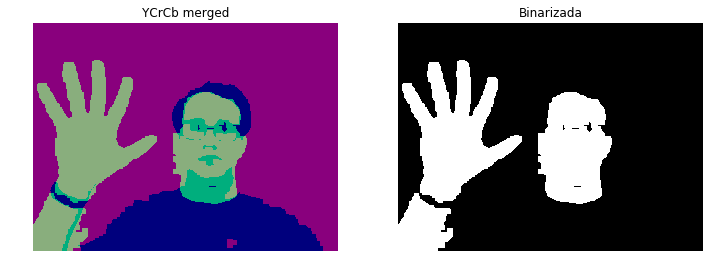

In [276]:
img = cv2.merge((y,cr,cb))

img1 = img.copy()

img2= cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
_, img3= cv2.threshold(img2, 100, 255, cv2.THRESH_BINARY)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(img1)
ax[0].set_title('YCrCb merged')
ax[0].set_axis_off()

ax[1].imshow(img3, cmap='gray')
ax[1].set_title('Binarizada')
ax[1].set_axis_off()

### Filtros para eliminação de ruídos

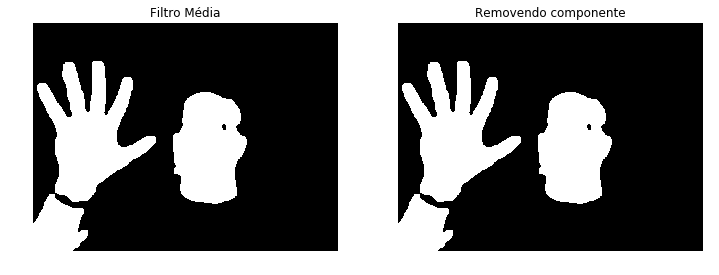

In [277]:
mask = backSub.apply(image)
img4 = cv2.bitwise_and(mask, img3)
img5 = cv2.medianBlur(img4, wsize_gaussian)
img5 = cv2.morphologyEx(img5, cv2.MORPH_OPEN, kernel)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(img5, cmap='gray')
ax[0].set_title('Filtro Média')
ax[0].set_axis_off()

img6 = remove_concomponent(img=img5, min_value=300)

ax[1].imshow(img6, cmap='gray')
ax[1].set_title('Removendo componente')
ax[1].set_axis_off()

### Removendo Face

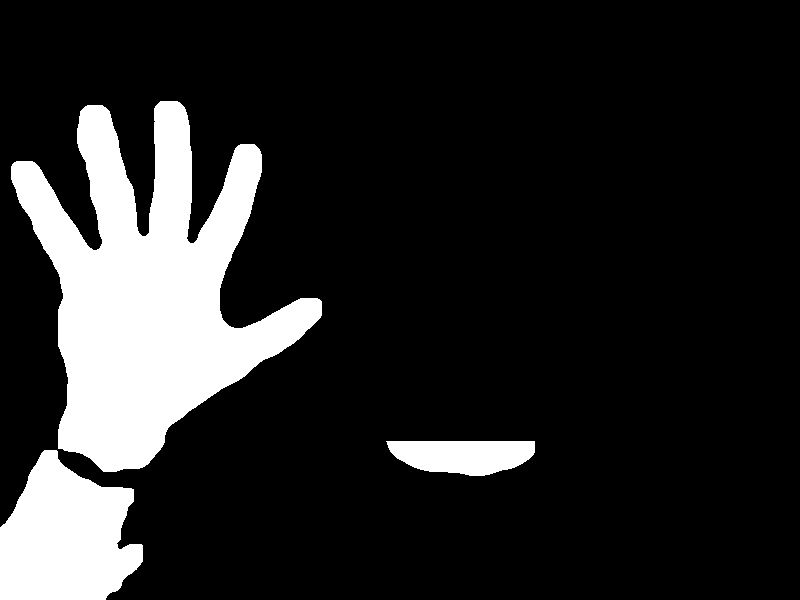

In [278]:
marge = 30
for (x, y, w, h) in faces:
    cv2.rectangle(img6, (x - marge, y - h + marge), (x + marge + w, y + marge + h), (0, 0, 0), -1)
    
cv2_imshow(img6)